In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# ✅ Create directory to save reconstructions
SAVE_DIR = './autoencoder_mnist'
os.makedirs(SAVE_DIR, exist_ok=True)


In [3]:
th train-on-mnist.lu

SyntaxError: invalid syntax (3432502855.py, line 1)

In [4]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 33.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.32MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.77MB/s]


In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [B, 32, 7, 7]
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # [B, 64, 1, 1]
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),              # [B, 32, 7, 7]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [B, 16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [B, 1, 28, 28]
            nn.Sigmoid()  # output between 0 and 1
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [8]:
model = ConvAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [9]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for imgs, _ in loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [27]:
def evaluate_and_visualize(model, loader, epoch):
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs[:16].to(DEVICE)
        recon = model(imgs)

        # Combine originals and reconstructions
        comparison = torch.cat([imgs.cpu(), recon.cpu()])  # [32, 1, 28, 28]
        grid = make_grid(comparison, nrow=16, padding=2)
        npimg = grid.numpy().transpose((1, 2, 0))  # [H, W, C] for imshow

        # Plot
        plt.figure(figsize=(15, 4))
        plt.imshow(npimg, cmap='gray')
        plt.axis('off')
        plt.title(f'Epoch {epoch}: Original (Top) | Reconstructed (Bottom)', fontsize=14)

        # Add column labels above each original image
        img_width = grid.shape[1] // 16
        for i in range(16):
            x_pos = i * img_width + 4
            plt.text(x_pos, 5, f'[{i}]', fontsize=10, color='yellow')

        # Save AND Show
        plt.savefig(os.path.join(SAVE_DIR, f'reconstruction_epoch_{epoch}.png'))
        plt.show()
        plt.close()


Epoch [1/10] | Train Loss: 0.0020


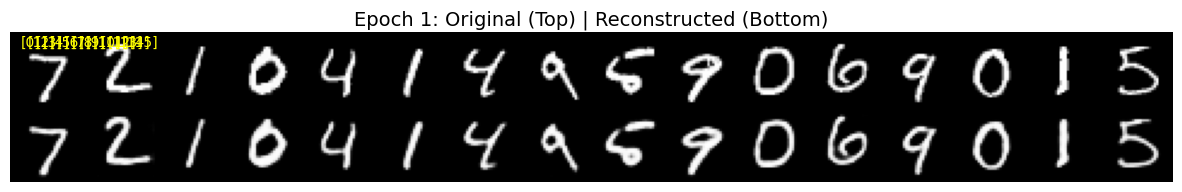

Epoch [2/10] | Train Loss: 0.0020


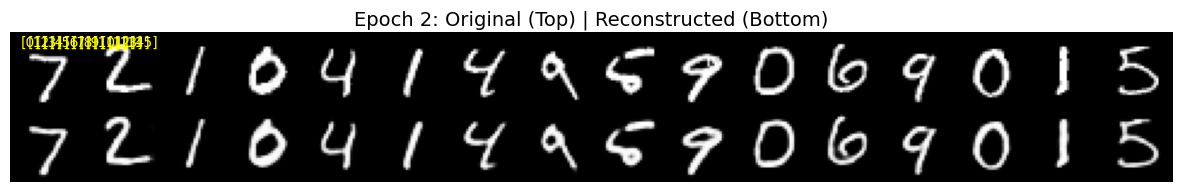

Epoch [3/10] | Train Loss: 0.0020


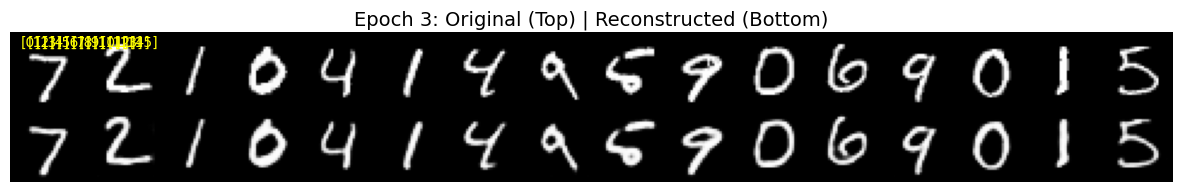

Epoch [4/10] | Train Loss: 0.0020


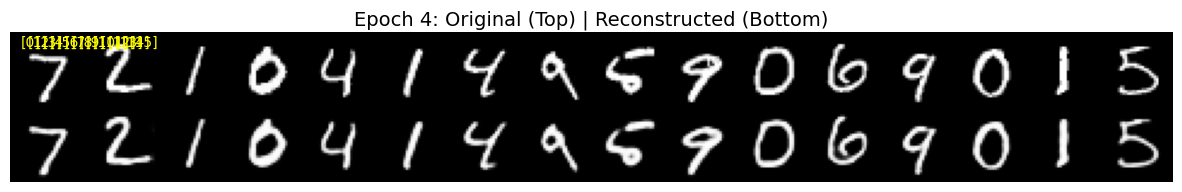

Epoch [5/10] | Train Loss: 0.0020


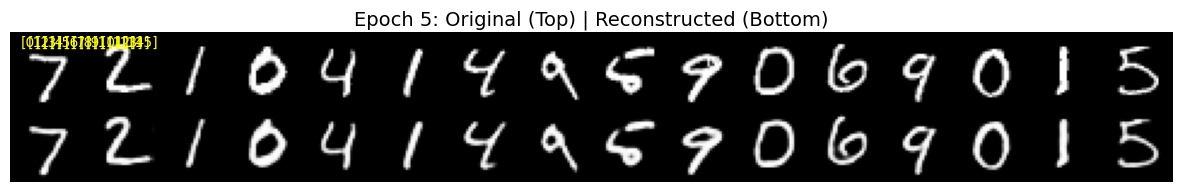

Epoch [6/10] | Train Loss: 0.0020


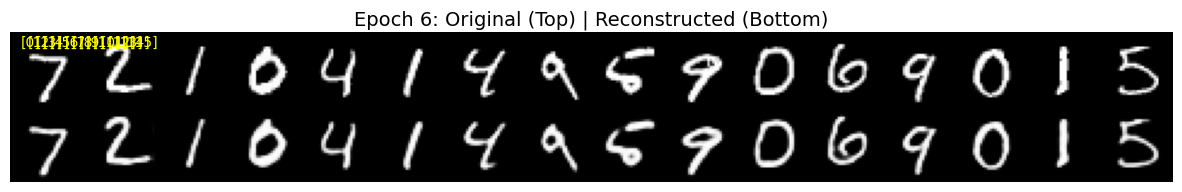

Epoch [7/10] | Train Loss: 0.0020


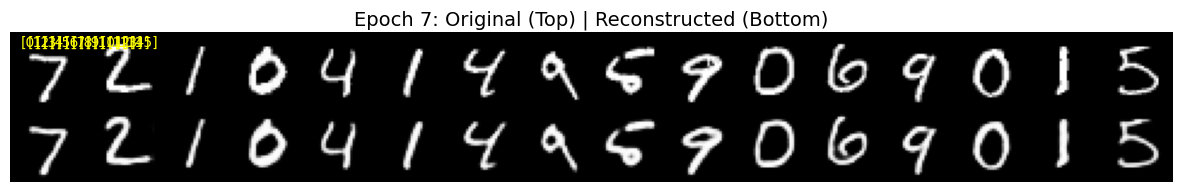

Epoch [8/10] | Train Loss: 0.0020


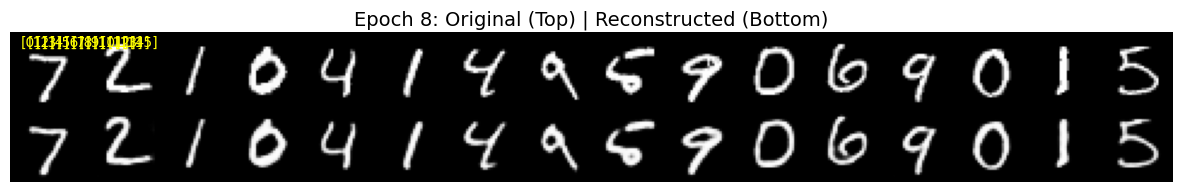

Epoch [9/10] | Train Loss: 0.0019


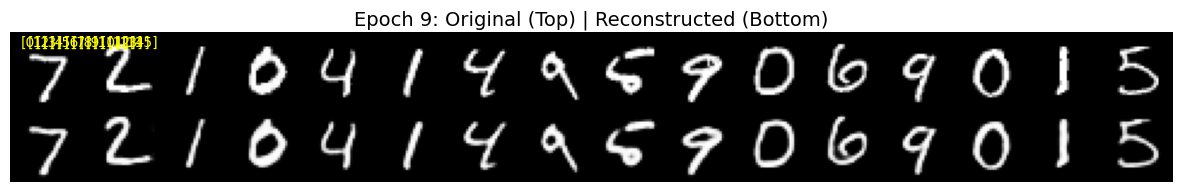

Epoch [10/10] | Train Loss: 0.0019


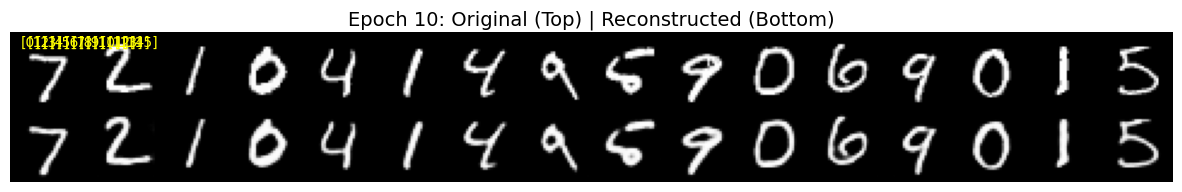

In [28]:
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    print(f"Epoch [{epoch}/{EPOCHS}] | Train Loss: {train_loss:.4f}")
    evaluate_and_visualize(model, test_loader, epoch)
